# Day of week seasonality of SPY

It could be very well possible that daily returns of SPY are dependant on the day of the week. There are many potential reasons for that, like some traders would be happy to close their positions before the weekend or be cautious about opening new ones on Monday. 

Some traders are using seasonality as an extra boost to their performance, [Quantified Strategies](http://www.quantifiedstrategies.com/day-of-week-seasonality-in-sp-500/). 

Let's do our own analysis and at the same time learn to use some `pandas` functions and how to work with dates and times. Pandas by itself has an [excellent documentation](http://pandas.pydata.org/pandas-docs/stable/index.html), so I will refer to it when necessary.

**Reading material** : Chapter 5 of the PDA book. 

**Note**: you need the [`tradingWithPython`](http://www.tradingwithpython.com/?page_id=504) library to get SPY price data. 

First, let's load all the scientific libraries and put all the figures in the notebook instead of popup windows.

In [6]:
%pylab inline
%run common.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tradingWithPython as twp
import pandas as pd
print('Pandas version:', pd.__version__) # print current pandas version


Pandas version: 0.21.0


## Get the data
`getHistoricalData` requests data from yahoo finance and returns it as a nice [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) object. DataFrame is a 2-dimensional array, very similar to an excel spreadsheet. It has column names and row labels (index)

In [3]:
data = twp.yahooFinance.getHistoricData('SPY') # get maximum history length from yahoo

data

Got 4588 days of data


,open,high,low,close,adj_close,volume
Date,,,,,,
1999-12-31,146.84,147.50,146.25,146.88,104.42,3172700
2000-01-03,148.25,148.25,143.88,145.44,103.39,8164300
2000-01-04,143.53,144.06,139.64,139.75,99.35,8089800
2000-01-05,139.94,141.53,137.25,140.00,99.53,12177900
2000-01-06,139.62,141.50,137.75,137.75,97.93,6227200
...,...,...,...,...,...,...
2018-03-21,270.90,273.27,270.19,270.43,270.43,78709600
2018-03-22,267.91,268.87,263.36,263.67,263.67,148785900
2018-03-23,264.17,264.54,257.83,258.05,258.05,183534800


At this moment I am only interested in `adj_close` (adjusted close) price, so I'll copy it to a new [Series](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#series) called *price* . Series is a 1-dimensional array (only a single column from DataFrame), but it is still indexed with row labels, which are in our case dates

<IPython.core.display.Javascript object>


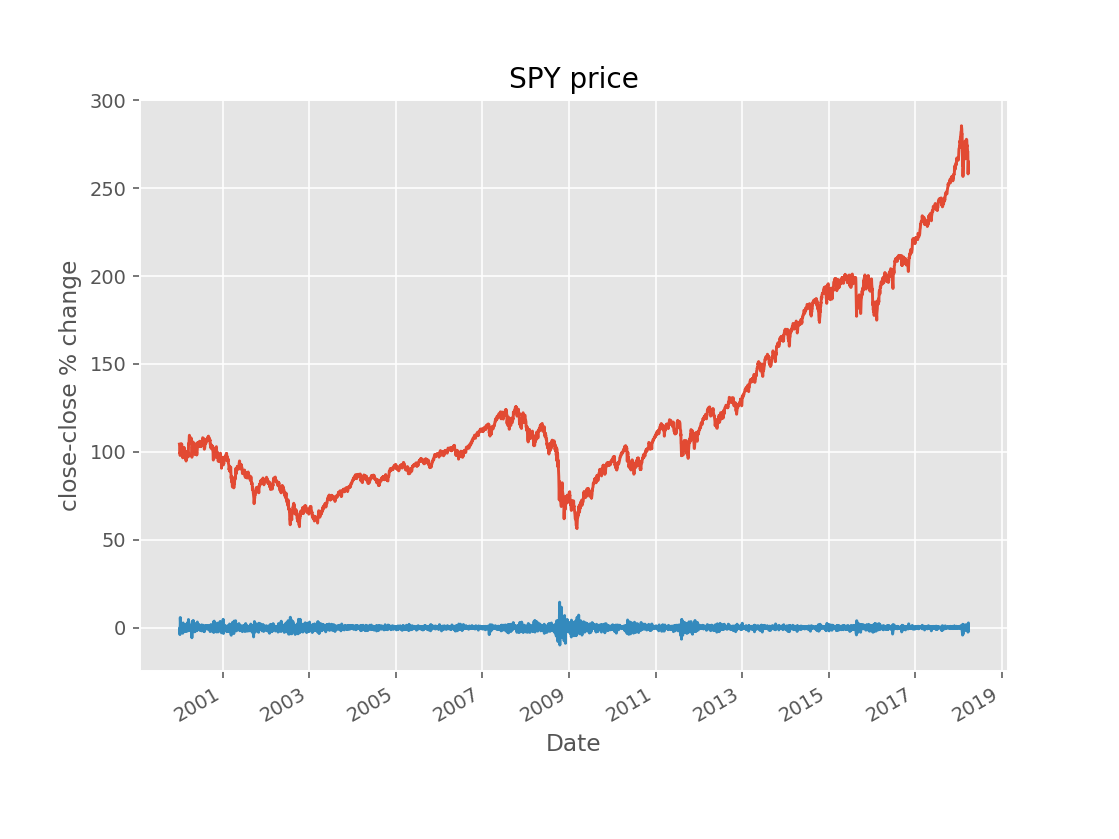

In [4]:
price = data['adj_close'] # get only one column from full data table
import matplotlib
matplotlib.style.use('ggplot') # nice figures
price.plot() # pandas objects have very convenient plot functions.
title('SPY price') 
ylabel('$')


To analyse daily seasonality we need daily returns instead of prices. 

In [5]:
ret = price.pct_change()  # calculating returns is also easy with pandas. Just call .pct_change() 
(100*ret).plot() # plot % return
ylabel('close-close % change')

Now we have daily returns ready for analysis. Before we go futher, I will insert a short intermezzo on working with dates and times.

## Working with dates and times 
[ref]: # (datetime - to and from strings)
Some very good examples of converting dates and times are found on the [PEAC Python](http://pleac.sourceforge.net/pleac_python/datesandtimes.html) site. Nevertheless I will sum up a couple of frequently used tricks:

In [6]:
import datetime as dt # shorthand notation for datetime module

Here we will get todays date as standard `date` type and convert it to `string`

In [7]:
today = dt.date.today() # get todays date
print(today) # print it
print(type(today)) # get the type, note that it is of datetime.date type, so not a string (even if it prints on the previous line)
s = today.strftime('%Y.%m.%d') # this is how to conert date type to a string: use .strftime()
print(type(s))
print('Today is ' , s) 

2018-02-21
<class 'datetime.date'>
<class 'str'>
Today is  2018.02.21


We can use almost any type of [format](http://www.tutorialspoint.com/python/time_strftime.htm) to convert date to a string:

In [8]:
print(today.strftime('%Y-%b-%d')) 
print(today.strftime('%d/%B/%Y (%a)'))


2018-Feb-21
21/February/2018 (Wed)


Converting back is easy with `strptime()` funcion, **but**: you must use `datetime` class of the `datetime` module instead of `date` class

In [9]:
dateAndTime = dt.datetime.strptime('20120803  21:59:59',"%Y%m%d %H:%M:%S") # convert string to a datetime class
print(type(dateAndTime), dateAndTime) # yes, it is datetime...
onlyDate = dateAndTime.date() # use .date() to convert to date class
print(type(onlyDate), onlyDate) # and now it is only date!



<class 'datetime.datetime'> 2012-08-03 21:59:59
<class 'datetime.date'> 2012-08-03


Another helpful function of the `date` class is`.isoweekday()` 

In [10]:
print(today.isoweekday()) # return current day number (1=Monday, 2=Tuesday etc)

3


## Analyse weekday seasonality
to do this, I will write a function that splits a series to a 5-column table, each column for each business day of the week. There are definately other ways to achieve the same result, but this is wat seemed logical to me. Don't expect to understand this code right away, take the time to read the comments.

In [11]:
def splitToWeekDays(s):
    ''' 
    return a dataframe where each weekday has a separate column 
    Parameters:
    ------------
    s - Series , with dates as index
    
    Returns:
    ----------
    dataFrame with business days as columns

    '''
    df = pd.DataFrame(index=s.index) # create empty DataFrame 
    df['data'] = s # add column named data, containing values from s
    df['weekday'] = 0 # add column named weekday, init with zeros
    
    
    for date in df.index: # for each date 
        dayNr = date.date().isoweekday() # get weekday number
        df.at[date,'weekday'] =dayNr # set day number for this date in 'weekday column'
    
    out = pd.DataFrame(index=df.index,columns = list(range(1,6))) # create empty DataFrame with 5 columns for each bus. day. 
                                                         # this 'out' DataFrame will be the result of this function
    
    for iDay in range(1,6): # now copy data from df to out
        out[iDay] = df[df['weekday']==iDay]['data'] # get selection, copy to 'out' dataframe

    out = out.fillna(value=0) # replace missing values with zeros
    out.columns = ['Mo','Tu','We','Th','Fr'] # replace number with day names
    return out 

Now the function can be used:

In [12]:
dayRet = splitToWeekDays(ret) # split series to daily returns
dayRet.tail(10) # print last 10 entries


,Mo,Tu,We,Th,Fr
Date,,,,,
2018-02-06,0.00,1.97e-02,0.00e+00,0.00,0.00e+00
2018-02-07,0.00,0.00e+00,-5.42e-03,0.00,0.00e+00
2018-02-08,0.00,0.00e+00,0.00e+00,-0.04,0.00e+00
2018-02-09,0.00,0.00e+00,0.00e+00,0.00,1.50e-02
2018-02-12,0.01,0.00e+00,0.00e+00,0.00,0.00e+00
2018-02-13,0.00,2.49e-03,0.00e+00,0.00,0.00e+00
2018-02-14,0.00,0.00e+00,1.35e-02,0.00,0.00e+00
2018-02-15,0.00,0.00e+00,0.00e+00,0.01,0.00e+00
2018-02-16,0.00,0.00e+00,0.00e+00,0.00,2.93e-04


Now if we would have 5 long portfolios trading `$100` for each day of the week, this is how they would perform (frictionless of course):

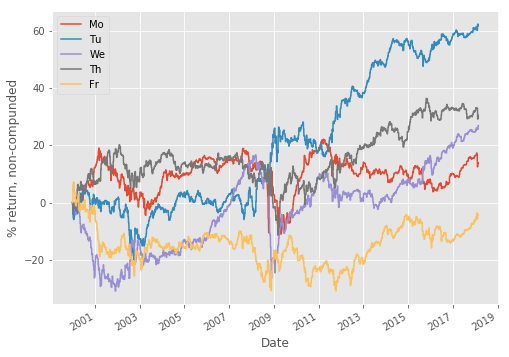

In [13]:
(100*dayRet).cumsum().plot(grid=True) #note the .cumsum() instead of .cumprod(), I assume the portfolio is rebalanced each time.
ylabel('% return, non-compunded')

Daily average returns look like this:

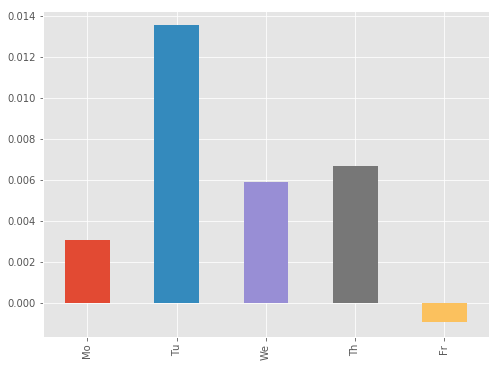

In [14]:
(100*dayRet).mean().plot(kind='bar')


...There is only a very tiny bias to the upside, with Tuesday scoring the best and Thursday being least favourable
    But how stable has this behavior been over time? We'll now compare two halves of this dataset. Here I use `.ix[col,row]` indexing to select data.

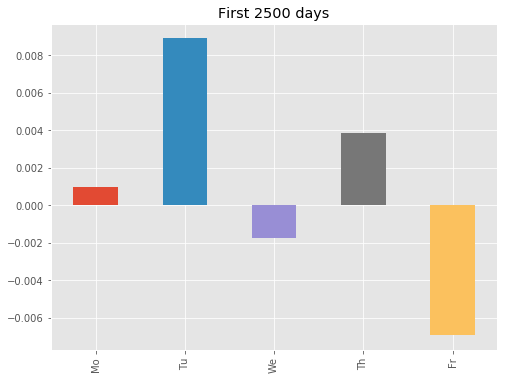

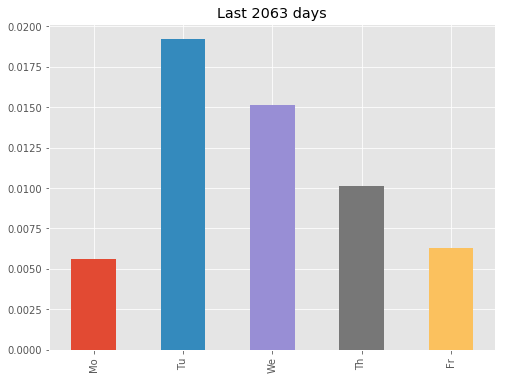

In [15]:
# ... sorry for 1-liners...
(100*dayRet.iloc[:2500,:]).mean().plot(kind='bar') # .ix[:2500,:] indexing selects first 2500 days of data
title('First 2500 days')
figure()
(100*dayRet.iloc[2500:,:]).mean().plot(kind='bar') # .ix[2500:,:] indexing selects data after 2500 days
title('Last %i days' % len(dayRet.iloc[2500:,:]))
 

From the charts above it seems that the daily seasonality got stronger over the years.
And finally the data for year to date:

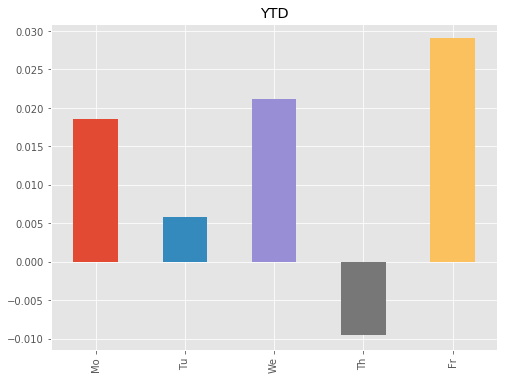

In [16]:
(100*dayRet.iloc[-250:,:]).mean().plot(kind='bar')
title('YTD')

Tuesday is now lees significant compared to other days